In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage.filters import threshold_sauvola

## detect lung

In [3]:
def detect_lungs_grid2(image_path, outdir="lungs_steps"):
    file_name = os.path.basename(image_path)
    os.makedirs(outdir, exist_ok=True)

    # Baca gambar
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Gagal membaca gambar, periksa path input.")

    canvas_height = 512
    canvas_width = 512
    img = cv2.resize(img, (canvas_width, canvas_height))

    # Gunakan Otsu untuk cari ambang optimal
    grayxx = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    otsu_thresh_val, _ = cv2.threshold(grayxx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Gunakan Otsu threshold sebagai batas bawah dan atas untuk Canny
    lower = int(otsu_thresh_val)
    #upper = int(otsu_thresh_val)
    upper = 200
    
    #edges = cv2.Canny(blur, lower, upper)
    # 2. Canny edge detection
    edges = cv2.Canny(img, lower, upper)
    

    # 5. Buat overlay edges berwarna merah di gambar CLAHE grayscale
    # Membuat mask warna merah (BGR) untuk edges
    edge_color = np.zeros_like(img)
    edge_color[edges != 0] = (0, 255, 255)  # merah dalam BGR

    #clahe_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    overlay_with_edges = cv2.addWeighted(img, 0.8, edge_color, 0.7, 0)
    
    # Kalau grayscale, ubah ke BGR untuk konsistensi
    gray0 = cv2.cvtColor(overlay_with_edges, cv2.COLOR_BGR2GRAY)
        

    
    steps = []  # list of (title, image, cmap)

    # 1. Original
    steps.append(("01. Original", img, None))

    steps.append(("02. Canny Edge "+str(otsu_thresh_val), edges, "gray"))

    steps.append(("03. Overlay Edges", overlay_with_edges, None))
    # 2. Grayscale
    steps.append(("04. Grayscale", gray0, "gray"))

    
    
    # 3. CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    gray_clahe = clahe.apply(gray0)
    steps.append(("03. CLAHE", gray_clahe, "gray"))

    
    

    # 4. Blur
    #gray_blur = cv2.medianBlur(gray_clahe, 3)
    #gray_blur = cv2.medianBlur(gray_clahe, 5)
    clahe_bgr = cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2BGR)

    # Terapkan mean shift
    mean_shift = cv2.pyrMeanShiftFiltering(clahe_bgr, sp=15, sr=30)
    
    # Kembali ke grayscale
    gray_blur = cv2.cvtColor(mean_shift, cv2.COLOR_BGR2GRAY)
    
    steps.append(("04. Mean Shift Filter", gray_blur, "gray"))
    
    # 5. Threshold
    #_, thresh = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #thresh = cv2.adaptiveThreshold( gray_blur, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11, 2)
    #modified 
    otsu_thresh_val, _ = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Turunkan threshold secara manual
    adjusted_thresh_val = otsu_thresh_val-5   # misal turunkan 20
    # Apply threshold manual dengan nilai baru
    _, thresh = cv2.threshold(gray_blur, adjusted_thresh_val, 255, cv2.THRESH_BINARY_INV)

    
    
    # 7. Gabungkan threshold + edges
    #combined = cv2.bitwise_or(thresh, edges)
    #steps.append(("07. Threshold + Canny", combined, "gray"))

    #if morped better
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    
    eroded = cv2.erode(thresh,kernel , iterations=2)
    steps.append(("06. eroded", eroded, "gray"))
    
    # 6. Morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    morphed = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel, iterations=2)
    #morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
    #morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    steps.append(("07. Morphology", morphed, "gray"))


    
    
    # 7. Top-2 Components
    #num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morphed, connectivity=8)
    #areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)]
    #areas = sorted(areas, key=lambda x: x[1], reverse=True)
    #keep = [i for i,_ in areas[:2]]
    #mask_top2 = np.zeros_like(morphed)
    #for i in keep:
    #    mask_top2[labels == i] = 255
    #steps.append(("07. Top-2 Components", mask_top2, "gray"))

    
    # 7. Improved Top-2 Lungs Extraction
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(morphed, connectivity=8)
    mask_top2 = np.zeros_like(morphed)
    
    # Image center (to split left/right lungs)
    h, w = morphed.shape
    image_center_x = w // 2
    
    lung_candidates = []
    
    for i in range(1, num_labels):  # skip background
        x, y, w_i, h_i, area = stats[i]
        cx, cy = centroids[i]

        # Sudut gambar
        h_img, w_img = morphed.shape
    
        # Cek apakah komponen menyentuh sudut gambar
        touches_top_left = (x <= 5 and y <= 5)
        touches_top_right = (x + w_i >= w_img - 5 and y <= 5)
        touches_bottom_left = (x <= 5 and y + h_i >= h_img - 5)
        touches_bottom_right = (x + w_i >= w_img - 5 and y + h_i >= h_img - 5)
    
        if any([touches_top_left, touches_top_right, touches_bottom_left, touches_bottom_right]):
            continue  # abaikan komponen yang menyentuh sudut

        # Cek apakah komponen menyentuh sisi gambar (atas/bawah/kiri/kanan)
        touches_top = y <= 5
        touches_bottom = y + h_i >= h_img - 5
        touches_left = x <= 5
        touches_right = x + w_i >= w_img - 5
        
        if any([touches_top, touches_bottom, touches_left, touches_right]):
            continue  # abaikan komponen yang menyentuh tepi
    
        # Lanjut filter lainnya
        aspect_ratio = h_i / (w_i + 1e-5)
        if (area > 3000 and             
            0.5 < aspect_ratio < 6.0 and  
            0.05 * w_img < cx < 0.95 * w_img):  
            lung_candidates.append((i, area))
    
    # Sort and select top 2
    top2 = sorted(lung_candidates, key=lambda x: x[1], reverse=True)[:2]
    for i, _ in top2:
        mask_top2[labels == i] = 255

    # 8. Contours
    contours, _ = cv2.findContours(mask_top2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #hull
    hull_contours = []
    for cnt in contours:
        hull = cv2.convexHull(cnt)
        hull_contours.append(hull)
    img_contour = img.copy()
    #cv2.drawContours(img_contour, contours, -1, (0,0,255), 2)

    cv2.drawContours(img_contour, hull_contours, -1, (0,0,255), 2)
    steps.append(("08. Contours", img_contour, None))

    # 9. Overlay
    hull_mask = np.zeros_like(mask_top2)
    cv2.drawContours(hull_mask, hull_contours, -1, 255, -1) 
    
    color_mask = np.zeros_like(img)
    color_mask[hull_mask ==255] = (0,255,0)
    overlay = cv2.addWeighted(img, 0.7, color_mask, 0.3, 0)
    steps.append(("09. Overlay", overlay, None))

    # 10. Masked lungs (clip mask)
    masked = cv2.bitwise_and(img, img, mask=hull_mask )
    steps.append(("10. Masked Lungs", masked, None))

    # --- Tampilkan grid 3x3 (atau lebih) ---
    n = len(steps)
    cols = 3
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(15, 5*rows))

    
    for i,(title,img,cmap) in enumerate(steps):
        plt.subplot(rows, cols, i+1)
        if img.ndim==2:
            plt.imshow(img, cmap=cmap if cmap else "gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
    
    plt.figure(figsize=(15, 5 * len(steps)))
    

    plt.tight_layout()
    plt.show()

    # Simpan hasil akhir
    #cv2.imwrite(os.path.join(outdir, "final_masked.png"), masked)
    #print(f"Hasil akhir disimpan di: {os.path.abspath(outdir)}")

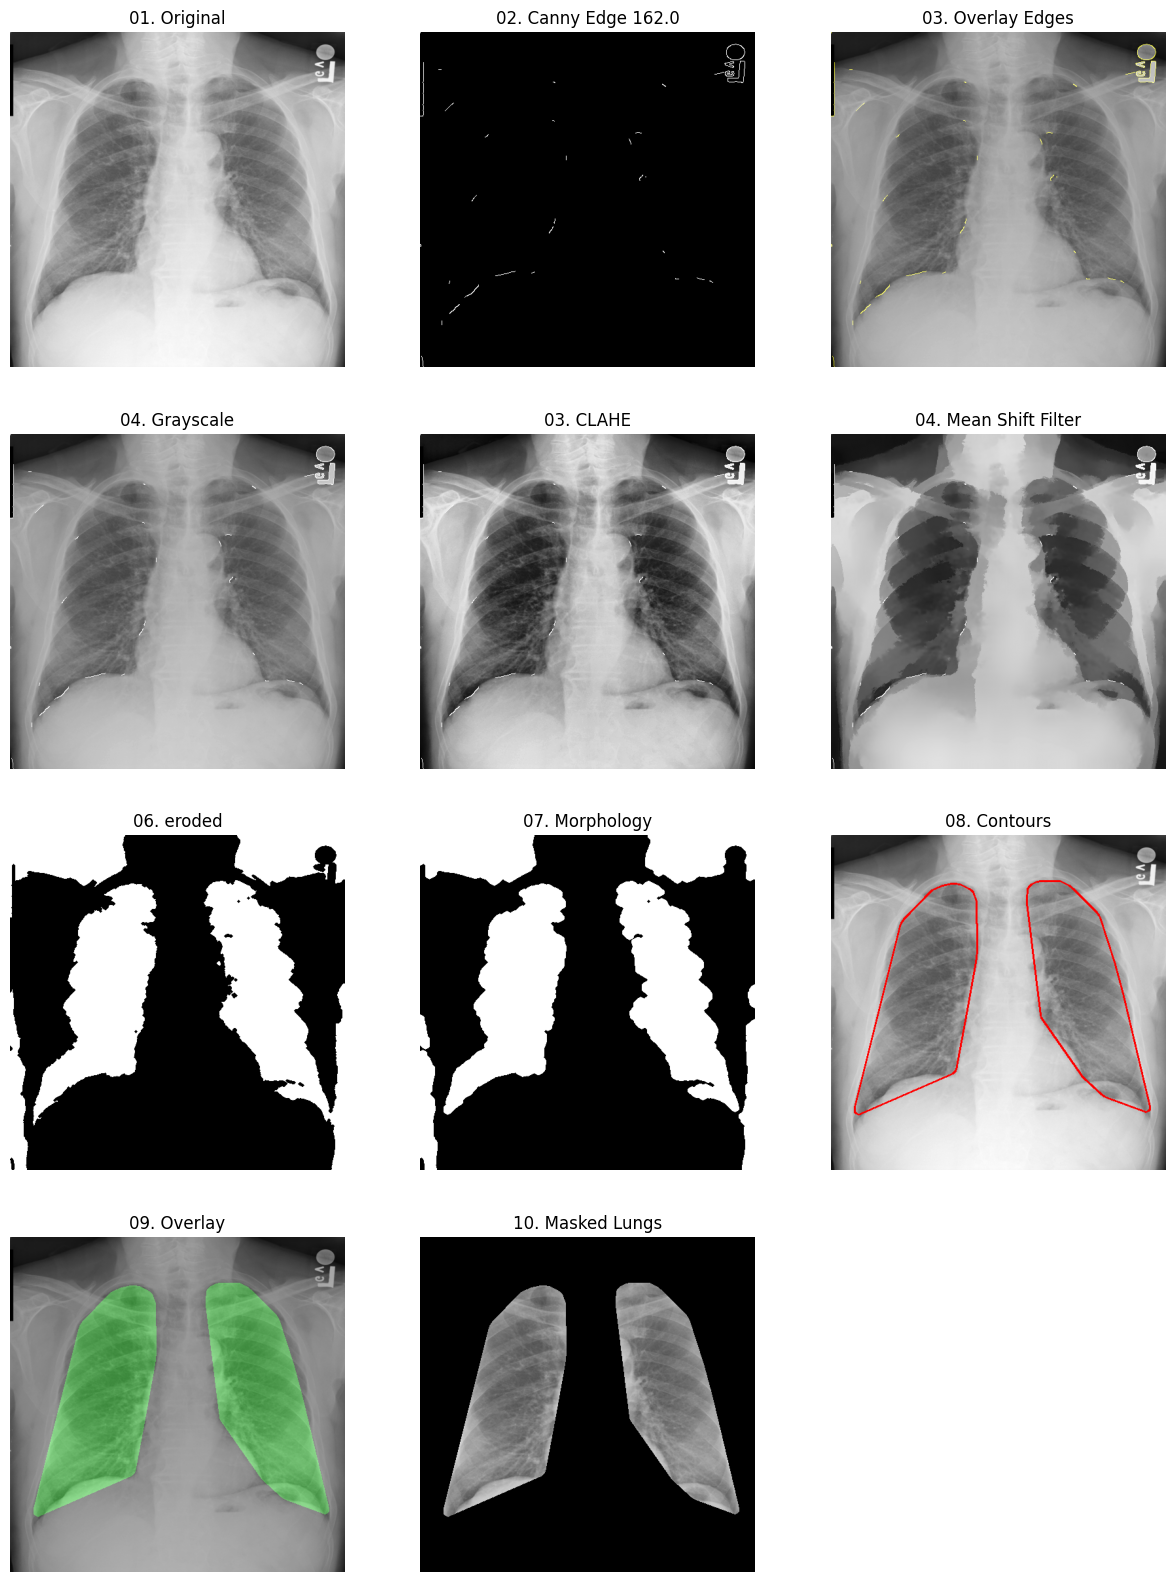

<Figure size 1500x5500 with 0 Axes>

In [5]:
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-6.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1896.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-779.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-951.png")
detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-19.png")

#satu
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1729.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1280.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-2.png")

#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-455.png")
#detect_lungs_grid2(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-2474.png")

# countour

In [60]:
# Define output canvas size (you can make this dynamic if needed)
canvas_height = 512
canvas_width = 512
contour_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

In [16]:
def detect_lungs_grid3(image_path,outdir="lungs_steps"):

    os.makedirs(outdir, exist_ok=True)

    # Baca gambar
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Gagal membaca gambar, periksa path input.")

    canvas_height = 512
    canvas_width = 512
    img = cv2.resize(img, (canvas_width, canvas_height))

    # Gunakan Otsu untuk cari ambang optimal
    grayxx = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    otsu_thresh_val, _ = cv2.threshold(grayxx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Gunakan Otsu threshold sebagai batas bawah dan atas untuk Canny
    lower = int(0.5 * otsu_thresh_val)
    upper = int(otsu_thresh_val)
    
    #edges = cv2.Canny(blur, lower, upper)
    # 2. Canny edge detection
    edges = cv2.Canny(img, lower, upper)
    

    # 5. Buat overlay edges berwarna merah di gambar CLAHE grayscale
    # Membuat mask warna merah (BGR) untuk edges
    edge_color = np.zeros_like(img)
    edge_color[edges != 0] = (0, 255, 255)  # merah dalam BGR

    #clahe_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    overlay_with_edges = cv2.addWeighted(img, 0.8, edge_color, 0.7, 0)
    
    # Kalau grayscale, ubah ke BGR untuk konsistensi
    gray0 = cv2.cvtColor(overlay_with_edges, cv2.COLOR_BGR2GRAY)
        

    
    #steps = []  # list of (title, image, cmap)

    # 1. Original
    #steps.append(("01. Original", img, None))

    #steps.append(("02. Canny Edge "+str(otsu_thresh_val), edges, "gray"))

    #steps.append(("03. Overlay Edges", overlay_with_edges, None))
    # 2. Grayscale
    #steps.append(("04. Grayscale", gray0, "gray"))

    
    
    # 3. CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    gray_clahe = clahe.apply(gray0)
    #steps.append(("03. CLAHE", gray_clahe, "gray"))

    
    

    # 4. Blur
    #gray_blur = cv2.medianBlur(gray_clahe, 3)
    #gray_blur = cv2.medianBlur(gray_clahe, 5)
    gray_blur = cv2.GaussianBlur(gray_clahe, (5, 5), 0)
    #steps.append(("04. Blur Median", gray_blur, "gray"))
    
    # 5. Threshold
    _, thresh = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #thresh = cv2.adaptiveThreshold( gray_blur, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11, 2)
    
    #steps.append(("05. Threshold", thresh, "gray"))

    
    
    # 7. Gabungkan threshold + edges
    #combined = cv2.bitwise_or(thresh, edges)
    #steps.append(("07. Threshold + Canny", combined, "gray"))

    #if morped better
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    
    eroded = cv2.erode(thresh,kernel , iterations=2)
    #steps.append(("07. eroded", eroded, "gray"))
    
    # 6. Morphology
    morphed = cv2.morphologyEx(eroded, cv2.MORPH_CLOSE, kernel, iterations=2)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
    #morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    #steps.append(("06. Morphology", morphed, "gray"))


    
    
    # 7. Top-2 Components
    #num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morphed, connectivity=8)
    #areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)]
    #areas = sorted(areas, key=lambda x: x[1], reverse=True)
    #keep = [i for i,_ in areas[:2]]
    #mask_top2 = np.zeros_like(morphed)
    #for i in keep:
    #    mask_top2[labels == i] = 255
    #steps.append(("07. Top-2 Components", mask_top2, "gray"))

    
    # 7. Improved Top-2 Lungs Extraction
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(morphed, connectivity=8)
    mask_top2 = np.zeros_like(morphed)
    
    # Image center (to split left/right lungs)
    h, w = morphed.shape
    image_center_x = w // 2
    
    lung_candidates = []
    
    for i in range(1, num_labels):  # skip background
        x, y, w_i, h_i, area = stats[i]
        cx, cy = centroids[i]

        # Sudut gambar
        h_img, w_img = morphed.shape
    
        # Cek apakah komponen menyentuh sudut gambar
        touches_top_left = (x <= 5 and y <= 5)
        touches_top_right = (x + w_i >= w_img - 5 and y <= 5)
        touches_bottom_left = (x <= 5 and y + h_i >= h_img - 5)
        touches_bottom_right = (x + w_i >= w_img - 5 and y + h_i >= h_img - 5)
    
        if any([touches_top_left, touches_top_right, touches_bottom_left, touches_bottom_right]):
            continue  # abaikan komponen yang menyentuh sudut

        # Cek apakah komponen menyentuh sisi gambar (atas/bawah/kiri/kanan)
        touches_top = y <= 5
        touches_bottom = y + h_i >= h_img - 5
        touches_left = x <= 5
        touches_right = x + w_i >= w_img - 5
        
        if any([touches_top, touches_bottom, touches_left, touches_right]):
            continue  # abaikan komponen yang menyentuh tepi
    
        # Lanjut filter lainnya
        aspect_ratio = h_i / (w_i + 1e-5)
        if (area > 3000 and             
            0.5 < aspect_ratio < 6.0 and  
            0.05 * w_img < cx < 0.95 * w_img):  
            lung_candidates.append((i, area))
    
    # Sort and select top 2
    top2 = sorted(lung_candidates, key=lambda x: x[1], reverse=True)[:2]
    for i, _ in top2:
        mask_top2[labels == i] = 255

    #steps.append(("07. Top-2 Components", mask_top2, "gray"))
    #random color
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # 8. Contours
    contours, _ = cv2.findContours(mask_top2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #return len(contours)
    cv2.drawContours(contour_canvas, contours, -1, color, 1)

In [17]:
detect_lungs_grid3(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1664.png")

## scandir

In [68]:
#reset
contour_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

image_folder = r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal"
all_files = os.listdir(image_folder)

# Filter for .png only
png_files = [f for f in all_files if f.lower().endswith('.png')]

## count contour

In [187]:
satu=0
dua=0
nol=0
for f in png_files[0:300]:
    patth=os.path.join(image_folder, f)
    cc = detect_lungs_grid3(patth)
    if cc == 1:
        satu = satu + 1
    elif cc == 2:
        dua = dua + 1
    elif cc == 0:
        nol = nol +1
total = satu+dua+nol

print("satu :",satu,". dua :",dua,". nol :",nol)
print("satu :",satu/total*100,". dua :",dua/total*100,". nol :",nol/total*100)



satu : 13 . dua : 275 . nol : 12
satu : 4.333333333333334 . dua : 91.66666666666666 . nol : 4.0


In [22]:
def detect_lungs_grid4(image_path, outdir="lungs_steps"):
    
    # Baca gambar
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Gagal membaca gambar, periksa path input.")

    # Resize (you need to define canvas_width and canvas_height externally or pass them in)
    img = cv2.resize(img, (contour_canvas.shape[1], contour_canvas.shape[0]))

    # Kalau grayscale, ubah ke BGR untuk konsistensi
    if img.ndim == 2:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        gray0 = img.copy()
    else:
        img_bgr = img.copy()
        gray0 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_clahe = clahe.apply(gray0)

    # Blur
    clahe_bgr = cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2BGR)

    # Terapkan mean shift
    mean_shift = cv2.pyrMeanShiftFiltering(clahe_bgr, sp=15, sr=30)
    
    # Kembali ke grayscale
    gray_blur = cv2.cvtColor(mean_shift, cv2.COLOR_BGR2GRAY)

    # Threshold
    _, thresh = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Connected components: Top-2 components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morphed, connectivity=8)
    areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)]
    areas = sorted(areas, key=lambda x: x[1], reverse=True)
    keep = [i for i,_ in areas[:2]]
    mask_top2 = np.zeros_like(morphed)
    for i in keep:
        mask_top2[labels == i] = 255

    # === Watershed Step ===
    # Noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(mask_top2, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # So that sure background is not 0, but 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_watershed = img_bgr.copy()
    markers = cv2.watershed(img_watershed, markers)
    # Boundary marked with -1

    # Optional: visualize watershed boundaries
    img_watershed[markers == -1] = [0, 0, 255]  # Red boundary

    # Generate mask from watershed (keep largest components that are not -1)
    watershed_mask = np.zeros_like(morphed)
    for i in np.unique(markers):
        if i <= 1:  # Skip background and border
            continue
        region = (markers == i).astype(np.uint8) * 255
        if cv2.countNonZero(region) > 500:  # Filter small regions
            watershed_mask[markers == i] = 255

    # Find contours from watershed mask
    contours, _ = cv2.findContours(watershed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.drawContours(contour_canvas, contours, -1, color, 1)

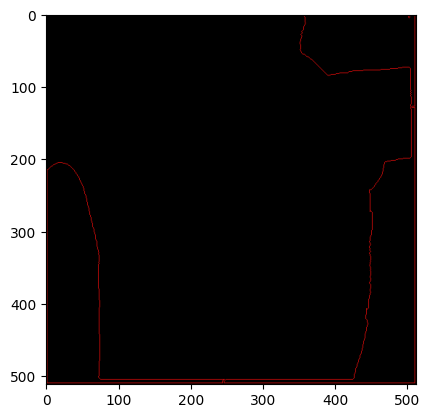

In [33]:
contour_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-2.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-3.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-4.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-5.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1896.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-779.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-951.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-19.png")

#satu
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1729.png")
detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-1280.png")
#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-2.png")



#detect_lungs_grid4(r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-2474.png")
plt.imshow(cv2.cvtColor(contour_canvas, cv2.COLOR_BGR2RGB))
plt.show()


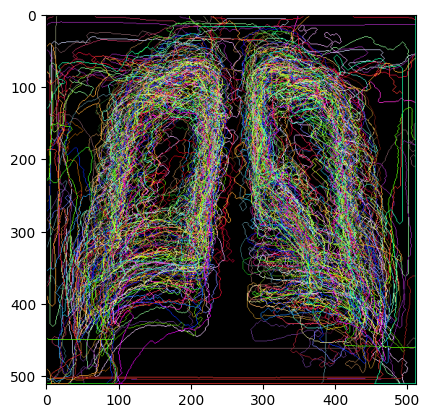

In [50]:


# Print full path
#subset = png_files[5:11]
for f in png_files[100:200]:
    patth=os.path.join(image_folder, f)
    detect_lungs_grid3(patth)
plt.imshow(cv2.cvtColor(contour_canvas, cv2.COLOR_BGR2RGB))
plt.show()

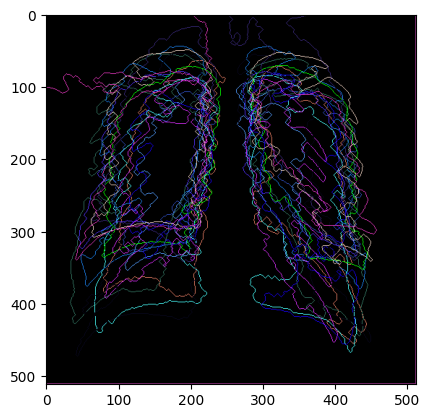

In [46]:
plt.imshow(cv2.cvtColor(contour_canvas, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
import cv2
import numpy as np

def detect_lungs_meanshift(image_path):
    """
    Deteksi paru menggunakan Mean Shift + threshold + connected components.
    Menghasilkan 2 mask: paru kiri & paru kanan.
    """
    resize_to=512
    # ======================
    # 1. LOAD & RESIZE
    # ======================
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Gambar tidak ditemukan!")

    img = cv2.resize(img, (resize_to, resize_to))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ======================
    # 2. CLAHE (penguatan kontras)
    # ======================
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(3,3))
    clahe_img = clahe.apply(gray)

    # ======================
    # 3. MEAN SHIFT FILTER
    # ======================
    clahe_bgr = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)
    ms = cv2.pyrMeanShiftFiltering(clahe_bgr, sp=15, sr=30)

    gray_ms = cv2.cvtColor(ms, cv2.COLOR_BGR2GRAY)

    # ======================
    # 4. OTSU THRESHOLD
    # ======================
    _, thresh = cv2.threshold(gray_ms, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # ======================
    # 5. MORPHOLOGY (bersihkan noise)
    # ======================
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    h, w = morphed.shape
    middle = w // 2

    # ======================
    # 6. SPLIT LEFT & RIGHT
    # ======================
    left_half = morphed[:, :middle]
    right_half = morphed[:, middle:]

    # ======================
    # 7. CONNECTED COMPONENTS PER SIDE
    # ======================
    def extract_largest_component(binary_mask):
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

        if num_labels <= 1:
            return np.zeros_like(binary_mask)

        # index 0 = background → skip
        areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)]
        largest_label = max(areas, key=lambda x: x[1])[0]

        mask = np.zeros_like(binary_mask)
        mask[labels == largest_label] = 255
        return mask

    left_lung = extract_largest_component(left_half)
    right_lung = extract_largest_component(right_half)

    # Kembalikan ke ukuran full gambar (gabungkan kiri + kanan)
    mask_full = np.zeros_like(morphed)
    mask_full[:, :middle] = left_lung
    mask_full[:, middle:] = right_lung

    # ======================
    # 8. MASK OVERLAY
    # ======================
    color_mask = np.zeros_like(img)
    color_mask[mask_full == 255] = (0, 255, 0)  # Hijau
    overlay = cv2.addWeighted(img, 0.7, color_mask, 0.3, 0)

    # Output dict lengkap
    return {
        "img": img,
        "clahe": clahe_img,
        "mean_shift": gray_ms,
        "thresh": thresh,
        "morphed": morphed,
        "left_lung": left_lung,
        "right_lung": right_lung,
        "mask_full": mask_full,
        "overlay": overlay
    }


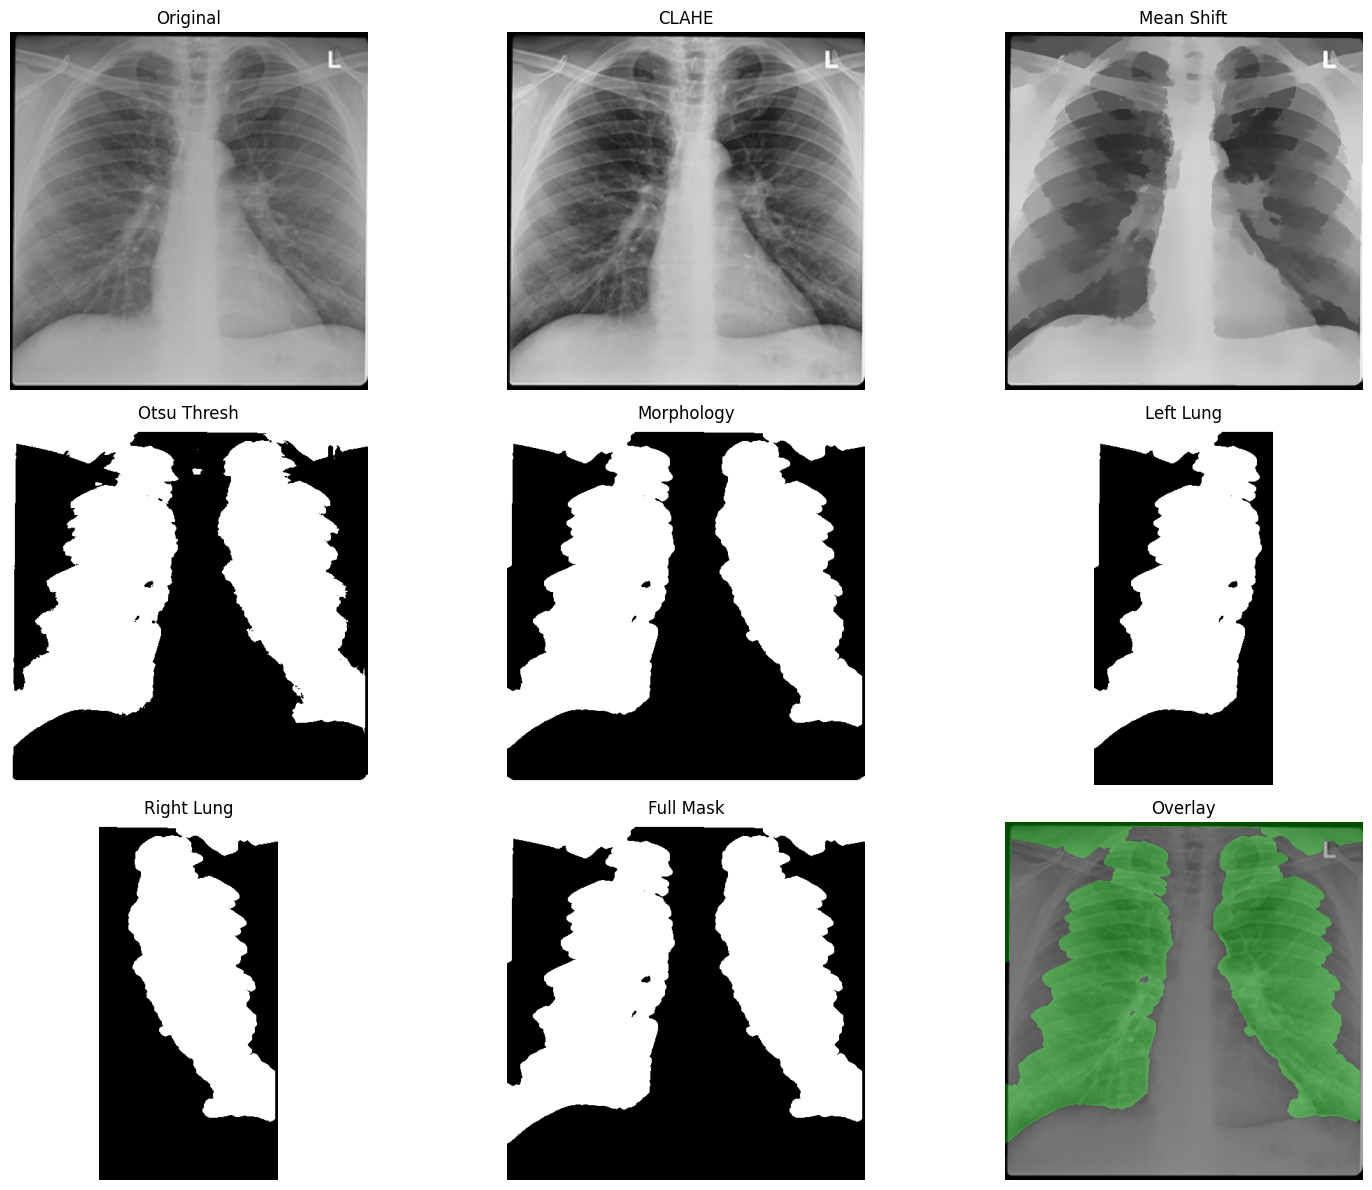

In [18]:
import matplotlib.pyplot as plt
import cv2

# ====== TEST IMAGE PATH ======
test_image = r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Normal\Normal-2.png"   # ganti dengan file kamu
test_image = r"D:\project\python\2025\tbcdetect\dataset2\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-6.png"

# Jalankan deteksi
results = detect_lungs_meanshift(test_image)

# Ambil semua hasil
titles = [
    "Original", "CLAHE", "Mean Shift",
    "Otsu Thresh", "Morphology", "Left Lung",
    "Right Lung", "Full Mask", "Overlay"
]

images = [
    cv2.cvtColor(results["img"], cv2.COLOR_BGR2RGB),
    results["clahe"],
    results["mean_shift"],
    results["thresh"],
    results["morphed"],
    results["left_lung"],
    results["right_lung"],
    results["mask_full"],
    cv2.cvtColor(results["overlay"], cv2.COLOR_BGR2RGB),
]

# Buat grid plot
plt.figure(figsize=(16, 12))
rows = 3
cols = 3

for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(rows, cols, i + 1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()
